## This code create an LSTM model

In [5]:
import os
import wfdb
import numpy as np
import pandas as pd
import ast
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import wfdb
from scipy.signal import welch
print(os.path.exists("../data/records500"))



True


In [7]:
def get_label(scp_codes):
    if "AFIB" in scp_codes:
        return 1
    if "NORM" in scp_codes:
        return 0
    if "AFLT" in scp_codes:
        return 2
    
    if "NDT" in scp_codes:
        return 4
    if "NST_" in scp_codes:
        return 5
    if "SVARR" in scp_codes:
        return 6
    if "SVTAC" in scp_codes:
        return 7
    if "PAC" in scp_codes:
        return 8
    return None




def load_ptbxl_metadata(dataset_root):
    df = pd.read_csv(os.path.join(dataset_root, "ptbxl_database.csv"))

    meta = {}
    for _, row in df.iterrows():
        scp_codes = ast.literal_eval(row["scp_codes"])
        
        label = get_label(scp_codes)
        if label is None:
            continue

        # NORMALIZE PATH (important!)
        key = row["filename_hr"].replace("\\", "/")

        meta[key] = {
            "ecg_id": int(row["ecg_id"]),
            "patient_id": int(row["patient_id"]),
            "label": label,
        }

    return meta


In [8]:
def scan_records500(dataset_root, meta):
    records500_root = os.path.join(dataset_root, "records500")

    records = []
    skipped = 0

    for subdir in sorted(os.listdir(records500_root)):
        subdir_path = os.path.join(records500_root, subdir)
        if not os.path.isdir(subdir_path):
            continue

        for fname in os.listdir(subdir_path):
            if not fname.endswith(".hea"):
                continue

            stem = fname[:-4]  # remove .hea

            # FORCE FORWARD SLASHES
            key = f"records500/{subdir}/{stem}"

            if key not in meta:
                skipped += 1
                continue

            info = meta[key]

            records.append({
                "hea_path": os.path.join(subdir_path, fname),
                "dat_path": os.path.join(subdir_path, stem + ".dat"),
                "label": info["label"],
                "patient_id": info["patient_id"],
                "ecg_id": info["ecg_id"],
            })
            
    
   
    print(f"Total 500 Hz records loaded: {len(records)}")
    print(f"Records skipped (no metadata): {skipped}")
    


    return records

def ecg_read(patient_id):
    record = wfdb.rdrecord(patient_id) 
    ecg_signal = record.p_signal[:,0]  
    fs = record.fs
    return ecg_signal, fs


Total 500 Hz records loaded: 13503
Records skipped (no metadata): 8334
exaple record: {'hea_path': '../data/records500\\00000\\00001_hr.hea', 'dat_path': '../data/records500\\00000\\00001_hr.dat', 'label': 0, 'patient_id': 15709, 'ecg_id': 1}
AFIB records  : 1514
NORM records  : 9491
AFLT records: 56
NDT records: 1630
NST_ records: 492
SVARR records: 102
SVTAC records: 9
PAC records: 209


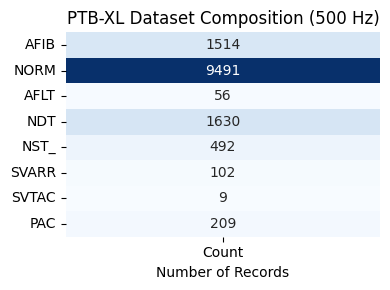

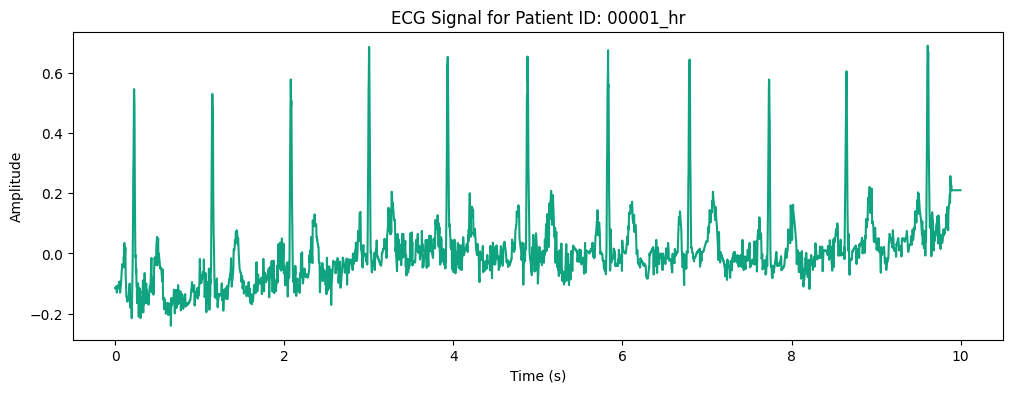

In [ ]:
dataset_root = "../data/"

meta = load_ptbxl_metadata(dataset_root)
records = scan_records500(dataset_root, meta)
afib_records = [r for r in records if r["label"] == 1]
norm_records = [r for r in records if r["label"] == 0]
aflt_records = [r for r in records if r["label"] == 2]
ndt_records = [r for r in records if r["label"] == 4]
nst_records = [r for r in records if r["label"] == 5]
svarr_records = [r for r in records if r["label"] == 6]
svtac_records = [r for r in records if r["label"] == 7]
pac_records = [r for r in records if r["label"] == 8]   

print("exaple record:", records[0])

print(f"Atrial Fibrillation (AFIB) records  : {len(afib_records)}")
print(f"Normal Sinus Rhythm (NORM) records  : {len(norm_records)}")
print(f"Atrial Flutter – regular atrial arrhythmia (AFLT) records : {len(aflt_records)}")
print(f"Non-Diagnostic T-wave Abnormalities (NDT) records : {len(ndt_records)}")
print(f"Non-Specific ST-T Changes (NST_) records : {len(nst_records)}")
print(f"Supraventricular Arrhythmia (SVARR) records : {len(svarr_records)}")
print(f"Supraventricular Tachycardia (SVTAC) records : {len(svtac_records)}")
print(f"Atrial Premature Contractions (PAC) records : {len(pac_records)}")

composition_df = pd.DataFrame({
    "Class": ["AFIB", "NORM", "AFLT", "NDT", "NST_", "SVARR", "SVTAC", "PAC"],
    "Count": [len(afib_records), len(norm_records), len(aflt_records), len(ndt_records), len(nst_records), len(svarr_records), len(svtac_records), len(pac_records)]
    })

composition_df



plt.figure(figsize=(4, 3))

sns.heatmap(
    composition_df.set_index("Class"),
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)

plt.title("PTB-XL Dataset Composition (500 Hz)")
plt.ylabel("")
plt.xlabel("Number of Records")
plt.tight_layout()
plt.show()

id= '00001_hr'
ecg_signal, fs = ecg_read(id)   
time = np.arange(ecg_signal.shape[0]) / fs


# Plot the ECG signals
plt.figure(figsize=(12, 4))
plt.plot(time, ecg_signal, '#10a37f')
plt.title(f'ECG Signal for Patient ID: {id}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()